<a href="https://colab.research.google.com/github/Ivan137950/Morse_decoder/blob/main/Kontur_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %kaggle competitions download -c morse-decoder
# %unzip morse-decoder.zip #for linux users

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
# %pip install python-Levenshtein
import Levenshtein
from Levenshtein import distance as levenshtein_distance
import random


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df.head(-5)

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ
...,...,...
29990,29991.opus,ФЬЧЗШЖШЦБ
29991,29992.opus,1ЬИЗЙРН С
29992,29993.opus,ШО3Ч Р4А
29993,29994.opus,2ЭИ КЙ4


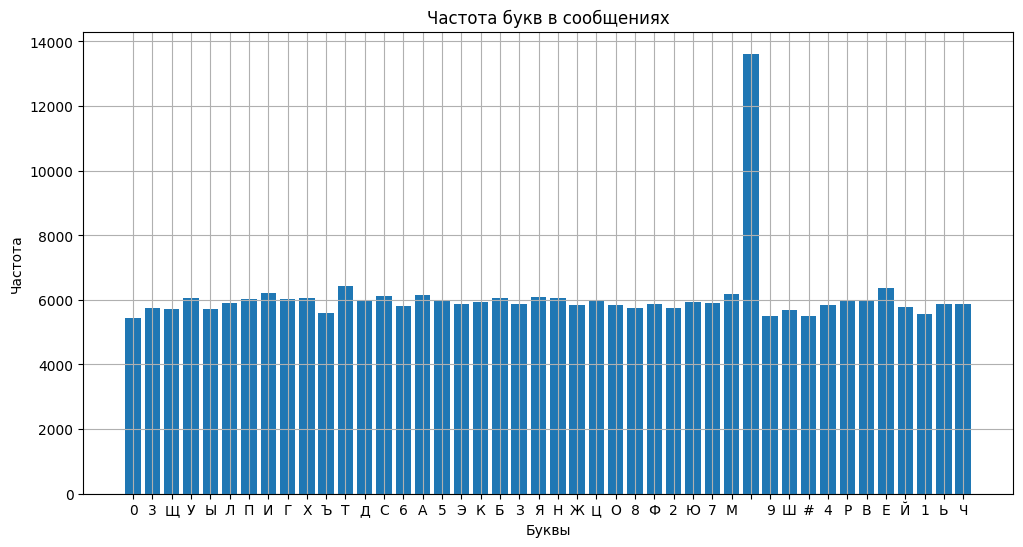

In [ ]:
counter = Counter()
for i in range(len(df)):
    counter.update(df['message'][i])


keys = list(counter.keys())
values = list(counter.values())

# Создание гистограммы
fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(keys, values)
plt.xlabel("Буквы")
plt.ylabel("Частота")
plt.title("Частота букв в сообщениях")
plt.grid(True)

In [ ]:


def extract_features(file_path):
    # Загрузка аудиофайла
    y, sr = librosa.load(file_path, sr=None)

    # Вычисление мел-спектрограммы
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)

    # Преобразование в дБ
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    return mel_spec_db, sr

# Путь к вашему аудиофайлу
path = "C:/Users/limon/Favorites/python_2024/kont/morse-decoder/morse_dataset/morse_dataset/"

mel_df = np.array([])

In [ ]:
print("start")
print("there were " + str(mel_df) + " read")

mel_list = []
for i in range(len(df['id'])):
    mel_spec_db, sr = extract_features(path + df['id'][i])
    mel_list.append(mel_spec_db)  #Ни в коем случае не менять на np.append, так как это будет очень долго
    if i % 1000 == 0:
        print(i, "read")
mel_df = np.array(mel_list)


start
there were [] read
0 read
1000 read
2000 read
3000 read
4000 read
5000 read
6000 read
7000 read
8000 read
9000 read
10000 read
11000 read
12000 read
13000 read
14000 read
15000 read
16000 read
17000 read
18000 read
19000 read
20000 read
21000 read
22000 read
23000 read
24000 read
25000 read
26000 read
27000 read
28000 read
29000 read


In [ ]:
mel_df.shape
data = mel_df.reshape(-1, mel_spec_db.shape[0], mel_spec_db.shape[1])
labels = df['message'].values
data.shape, labels.shape

((30000, 128, 126), (30000,))

локальная нормализация данных

In [ ]:
from sklearn.preprocessing import MinMaxScaler


def normalize_spec_per_example(spec):
    scaler = StandardScaler()
    spec_T = spec
    normed = scaler.fit_transform(spec_T)
    return normed

def normalize_spec_mm(spec):
    scaler = MinMaxScaler()
    normed = scaler.fit_transform(spec)
    return normed

X_normed = np.array([normalize_spec_per_example(spec) for spec in data]) # Хочу нормализовать каждый пример отдельно. Может быть, в этом есть смысл
# X_normed = np.array([normalize_spec_mm(spec) for spec in X_normed_1])



In [ ]:
labels_unique = set() # Набор уникальных символов
for label in labels:
    labels_unique.update(label)
labels_unique = list(labels_unique)
labels_unique.sort()
labels_unique_dict = {label: i + 1 for i, label in enumerate(labels_unique)}
labels_unique_dict["<blank>"] = 0


new_labels = [] # Список для новых меток
for label in labels:
     new_labels.append([labels_unique_dict[char] for char in label])
# new_labels[0], new_labels[1], new_labels[2], new_labels[3], new_labels[4]


spect_train, spect_val, y_train, y_val = train_test_split(X_normed, new_labels, test_size=0.2, shuffle=True)


---

Погдотовим датасеты для основной нейронной сети

---

In [ ]:
class SpeachDataset(Dataset):
    def __init__(self, input, words):
        self.input = input
        self.words = words
        # self.char_to_index = char_to_index

    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        # return super().__getitem__(index)
        mel_tesor = torch.tensor(self.input[index], dtype=torch.float32)
        word = self.words[index]
        label = torch.tensor([letter for letter in word], dtype=torch.long)
        return mel_tesor, label


def collate_fn(batch):
    mels, targets = zip(*batch)

    input_lengths = torch.tensor([mel.shape[0] for mel in mels], dtype=torch.long)
    mels_padded = torch.stack(mels, dim=0)

    target_lens = torch.tensor([t.shape[0] for t in targets], dtype=torch.long)
    targets_concat = torch.cat(targets)

    return input_lengths, mels_padded, target_lens, targets_concat


train_dataset_encoded = SpeachDataset(spect_train, y_train)
train_loader = DataLoader(train_dataset_encoded, batch_size=32, collate_fn=collate_fn, shuffle=True)

val_dataset_encoded = SpeachDataset(spect_val, y_val)
val_loader = DataLoader(val_dataset_encoded, batch_size=32, collate_fn=collate_fn, shuffle=False)
val_dataset_encoded.input.shape

(6000, 128, 126)

In [ ]:
for input_lengths, mels_padded, target_lengths, targets_concat in val_loader:
    print(input_lengths.shape, mels_padded.shape, target_lengths.shape, targets_concat.shape)
    break

torch.Size([32]) torch.Size([32, 128, 126]) torch.Size([32]) torch.Size([293])


Ряд нужных в будущем функций

In [ ]:
def clean_ctc_output(seq, blank=0):
    cleaned = []
    prev = None
    for x in seq:
        if x != blank and x != prev:
            cleaned.append(x)
        prev = x
    return cleaned


def greedy_decode(logits, blank=0):
    pred = torch.argmax(logits, dim=2).transpose(0, 1)
    decoded = []
    for seq in pred:
        decoded.append(clean_ctc_output(seq.cpu().tolist(), blank))
    return decoded


def split_targets(targets_concat, target_lens):
    targets = []
    offset = 0
    for length in target_lens:
        targets.append(targets_concat[offset:offset + length].tolist())
        offset += length
    return targets


def levenshtein_mean(decoded, targets):
    total = 0
    for pred, true in zip(decoded, targets):
        total += levenshtein_distance(pred, true)
    return total / len(decoded)



def bagging_dataset(data, new_labels, percantage=0.2):
    train_data, _, labels, _ = train_test_split(data, new_labels, test_size=percantage, shuffle=True)
    return train_data, labels

---

Модель

---

In [ ]:
class CTC_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, vocab_size, num_layers=2):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((1, 2))
        )

        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.GRU(256 * (input_dim // 16), hidden_dim, num_layers=num_layers, dropout=0.15, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)

    def forward(self, x):
        # print(f"изначальная форма: {x.shape}" )
        x = x.unsqueeze(1)
        x = self.cnn(x)
        # print(f"После CNN: {x.shape}")
        x = x.permute(0, 2, 1, 3)
        # print(f"После permute: {x.shape}")
        x = x.flatten(2)
        # print(f"После flatten: {x.shape}")
        x = self.dropout(x)
        output, _ = self.lstm(x)
        # print(f"После lstm: {output.shape}")
        logits = self.fc(output)
        # print(f"После Linear: {logits.shape}")
        return logits


In [ ]:
input_dim = 126
hidden_dim = 256
vocab_size = 45


In [ ]:
train_history, val_history, val_lev_history = [], [], []
epochs = random.randint(60, 100)
model = CTC_Model(input_dim, hidden_dim, vocab_size, num_layers=3).to(device)
# trained_model, train_history, val_history, val_lev_history = train_model(model, spect_train, y_train, val_loader=val_loader, epochs=epochs)

In [ ]:
print(device)

# def train_model(model, train_data, train_labels, val_loader, epochs=10):
train_histories =  []
epochs = 100
model.train()
train_dataset = SpeachDataset(spect_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CTCLoss(blank=0)

for epoch in range(100):
    # print(f"Epoch {epoch + 1}/{epochs}")
    if epoch > 5:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.001
    if epoch > 30:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0005
    if epoch > 50:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.00005
    model.train()
    total_loss = 0
    for i, batch in enumerate(train_loader):
        # if i % 100 == 0:
        #     print(f"Batch {i + 1}/{len(train_loader)}")
        # print(f"Batch {i + 1}/{len(train_loader)}")
        input_lengths, mels_padded, target_lens, targets_concat = batch

        input_lengths = input_lengths.to(device)
        mels_padded = mels_padded.to(device)
        target_lens = target_lens.to(device)
        targets_concat = targets_concat.to(device)

        optimizer.zero_grad()
        logits = model(mels_padded)
        logits = logits.log_softmax(2).transpose(0, 1)  # (T, N, C)

        loss = criterion(logits, targets_concat, input_lengths, target_lens)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_histories.append(avg_loss)

    #  Evaluate Levenshtein on validation set
    model.eval()
    val_lev_total = 0
    val_loss = 0
    total_samples = 0
    val_histories = []
    val_leven_histories = []
    with torch.no_grad():
        for batch in val_loader:
            input_lengths, mels_padded, target_lens, targets_concat = batch

            input_lengths = input_lengths.to(device)
            mels_padded = mels_padded.to(device)
            target_lens = target_lens.to(device)
            targets_concat = targets_concat.to(device)

            logits = model(mels_padded)
            logits = logits.log_softmax(2).transpose(0, 1)  # (T, N, C)

            decoded = greedy_decode(logits)
            targets = split_targets(targets_concat, target_lens)

            val_lev_total += sum(levenshtein_distance(p, t) for p, t in zip(decoded, targets))
            total_samples += len(targets)
            val_loss += criterion(logits, targets_concat, input_lengths, target_lens).item()

    val_lev_mean = val_lev_total / total_samples
    avg_val_loss = val_loss / len(val_loader)
    val_histories.append(avg_val_loss)
    val_leven_histories.append(val_lev_mean)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Levenshtein Mean Val: {val_lev_mean:.2f}")
    # return model, train_histories, val_histories, val_leven_histories
